In [3]:
# import the packages
import numpy as np
from scipy.io import loadmat
import cvxpy as cp

In [2]:
# -----------------------------------------------------------
# Step 1: Preprocessing (normalize to [-1,1])
# -----------------------------------------------------------
def normalize_signal(x):
    xmax = np.max(x[x > 0]) if np.any(x > 0) else 1
    xmin = np.min(x[x < 0]) if np.any(x < 0) else -1
    x_norm = np.zeros_like(x, dtype=float)

    x_norm[x > 0] = x[x > 0] / xmax
    x_norm[x < 0] = x[x < 0] / abs(xmin)

    return x_norm

In [29]:
# -----------------------------------------------------------
# Step 2: Sparse Linear Prediction (simplified AR coeffs)
# -----------------------------------------------------------
def slp_coefficients(y, K=20, gamma_range=np.logspace(-2, 2, 40)):
    """
    Sparse Linear Prediction with optimal gamma selection (Annex F.1.2).
    
    Args:
        x : 1D numpy array (input vibrotactile frame)
        K : int, prediction order
        gamma_range : array-like, values of gamma to try
    
    Returns:
        a_opt : numpy array, optimal SLP coefficients
        gamma_opt : float, selected gamma value
        coeff_norms : list of ||a||_1 values for each gamma
        residual_norms : list of ||x - Xa||_1 values for each gamma
    """
    N = len(y)
    # Construct regression matrix
    Y = np.zeros((N - K, K))
    y_target = y[K:]  # The values to predict
    
    for i in range(K):
        Y[:, i] = y[K - i - 1:N - i - 1]  # Shifted past samples

    residual_norms = []
    coeff_norms = []

    # Sweep gamma values
    for gamma in gamma_range:

        m, n = Y.shape
    
        # Variables
        a = cp.Variable(n)
        u = cp.Variable(m)  # residuals
        v = cp.Variable(n)  # for |a|
    
        # Constraints to represent L1 norms
        constraints = [
            Y @ a - y_target <= u,
            y_target - Y @ a <= u,
            a <= v,
            -a <= v,
            u >= 0,
            v >= 0
        ]
    
        # Objective
        objective = cp.Minimize(cp.sum(u) + gamma * cp.sum(v))
    
        # Problem
        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.SCS)  # You can also try cp.SCS

        r = y_target - Y @ a.value
        residual_norms.append(np.linalg.norm(r, 1))
        coeff_norms.append(np.linalg.norm(a.value, 1))

    residual_norms = np.array(residual_norms)
    coeff_norms = np.array(coeff_norms)

    return residual_norms, coeff_norms, r

In [30]:
# -----------------------------------------------------------
# Example Run
# -----------------------------------------------------------
if __name__ == "__main__":

    tooltip = "1spike_Probe" # 1spike_Probe, 3x1small-round_Probe, 3x1spike_Probe, 3x3_Probe, 3x3small-round_Probe, big-half-round_Probe, big-round_Probe, finger_Probe
    material = "rubber"  # BalticBrown, aluminiumGrid, antiVibPad, bamboo, cork, felt, foam, polyesterPad, rubber
    speed = "fast"  # medium, fast
    sampling_rate = 2800
    dct_quantization_scale = 1.0
    num_samples_per_frame = 200
    ar_order = 40

    acc_samples_filename = "./signal_trace_data/Direct_-_" + tooltip + "_-_" + material + "_-_" + speed + ".mat"

    data = loadmat(acc_samples_filename)
    material_samples = data["material"]

    acc_combined_cut_frame = material_samples["joinedAccPaperCut"][0,0]
    acc_combined_cut_frame = np.asarray(acc_combined_cut_frame).flatten()

    # Step 1: Normalize
    x_norm = normalize_signal(acc_combined_cut_frame)

    # Step 2: SLP coefficients
    residual_norms, coeff_norms, r = slp_coefficients(x_norm, K=ar_order)


/home/cwcyenk/miniconda3/lib/python3.12/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [31]:
print(np.log10(residual_norms), np.log10(coeff_norms))

[1.89693036 1.89693035 1.89693049 1.89693054 1.89693152 1.89693275
 1.89693684 1.89693796 1.89694617 1.89695118 1.89695805 1.89697918
 1.8970151  1.89708064 1.8971109  1.89716177 1.89729618 1.89744546
 1.8978161  1.89823718 1.89914751 1.90029598 1.90177107 1.9036156
 1.90630137 1.91047747 1.91622338 1.92101801 1.92625291 1.93160107
 1.93681907 1.94017534 1.94621397 1.95044708 1.95636217 1.95984086
 1.9653518  1.97568086 1.98837963 1.99639929] [0.59492281 0.5947879  0.59499339 0.59507404 0.59359005 0.59290372
 0.59083207 0.58998427 0.58754344 0.58615564 0.58444899 0.58085186
 0.57568875 0.56805407 0.56533506 0.56197349 0.55431661 0.54766869
 0.53391913 0.52165792 0.49943096 0.47626559 0.45057851 0.42427132
 0.39178887 0.34670516 0.29261081 0.25247166 0.21295103 0.17847782
 0.14949414 0.13386189 0.10962949 0.0956568  0.07964987 0.07218924
 0.0625255  0.0472395  0.03112887 0.02272568]


<StemContainer object of 3 artists>

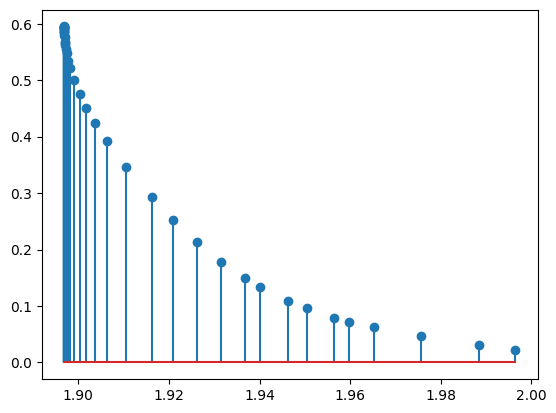

In [32]:
import matplotlib.pyplot as plt

plt.stem(np.log10(residual_norms), np.log10(coeff_norms))